Reference: Peltason L et al., Rationalizing three-dimensional activity landscapes and the influence of molecular representations on landscape topology and formation of activity cliffs., J Chem Inf Model 50, 1021-1033, 2010.

{'filename': 'data/solubility.test.sdf', 'nbits': 4096}


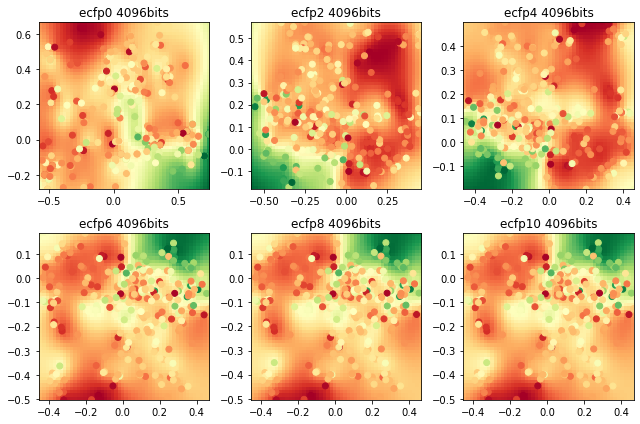

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
from sklearn import preprocessing
from rdkit import Chem
from rdkit.Chem import AllChem
import argparse

def pca(X, npc=2):
    # calculate eigenvalues(l) and eigenvectors(w) of the covariance matrix
    C = np.cov(X.T)
    l,w = np.linalg.eig(C)

    # sort eigenvectors by eigenvalue in descending order
    w = w[:,np.argsort(l)[::-1]]
    ''' T = X*W '''
    pc = np.dot(X, w[:,:npc])
    return pc

def fp_mds(args, radius):
    fps = []
    bit_info = {}
    solubility = []
    for mol in Chem.SDMolSupplier(args.filename):
        fp_bit = list(AllChem.GetMorganFingerprintAsBitVect(mol, radius, bitInfo=bit_info, nBits=args.nbits))

        # you can use fp_bit for fixed length fingerprints,
        # while this code generates matrix from variable length fingerprints for generality.
        fp = list(bit_info.keys())
        fps.append(fp)
        solubility.append(np.float32(mol.GetProp('SOL')))

    ncol = max(max(fp) if len(fp) > 0 else 0 for fp in fps)
    mat = np.zeros((len(fps), ncol+1), dtype=np.float32)
    for i, fp in enumerate(fps):
        mat[i, fp] = 1.

    mat = preprocessing.normalize(mat)
    pcs = np.real(pca(mat, npc=2))

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(pcs[:,0].min(), pcs[:,0].max()), np.linspace(pcs[:,1].min(), pcs[:,1].max())
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(pcs[:,0], pcs[:,1], solubility, function='linear', smooth=0.1)
    zi = rbf(xi, yi)

    plt.title('ecfp%d %dbits' % (radius, args.nbits))
    plt.imshow(zi, vmin=zi.min(), vmax=zi.max(), origin='lower', cmap='RdYlGn_r', aspect='auto',
            extent=[pcs[:,0].min(), pcs[:,0].max(), pcs[:,1].min(), pcs[:,1].max()])
    plt.scatter(pcs[:,0], pcs[:,1], c=solubility, cmap='RdYlGn_r')

def main():
    parser = argparse.ArgumentParser() 
    parser.add_argument('--filename', default='data/solubility.test.sdf')
    parser.add_argument('--nbits', default=4096, type=int)
    args = parser.parse_args([])

    print(vars(args))

    plt.figure(figsize=(9,6))
    for index, radius in enumerate([0, 2, 4, 6, 8, 10], 1):
        plt.subplot(2, 3, index)
        fp_mds(args, radius)
    plt.tight_layout()
    plt.savefig('doc/fp.png')

if __name__ == '__main__':
    main()